<a href="https://colab.research.google.com/github/aknsntn/math_ml/blob/main/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%B0%D1%86%D0%B8%D0%B8%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import *

import numpy as np
import pandas as pd

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [ ]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

# Нейрон с ReLU (Recitified Linear Unit)

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu(x):
    """ReLU-функция"""
    return (x > 0) * x

In [ ]:
def relu_derivative(x):
    """Производная ReLU"""
    return (x > 0) * 1

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w -= learning_rate * (X.T @ (sigma - y)) / n
        self.b -= learning_rate * np.mean(sigma - y)

    def predict(self, X):
      
        return np.absolute(np.around(self.forward_pass(X)))
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

# Добавим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/apples_pears.csv')
df

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0
...,...,...,...
995,0.288482,0.051186,0.0
996,0.892424,0.795257,0.0
997,0.927219,0.134986,1.0
998,0.015830,0.481322,0.0


In [ ]:
X = df.iloc[:,:2].values
y = df['target'].values.reshape((-1, 1))

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)
print(data.shape)
data.head()

(3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [ ]:
X_v = data.drop(columns='label').values
y_v = data['label'].values

In [ ]:
scaler = MinMaxScaler()
X_v = scaler.fit_transform(X_v)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3)
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(X_v, y_v, train_size = 0.3)

# Проверка ReLu

### Яблоки и груши

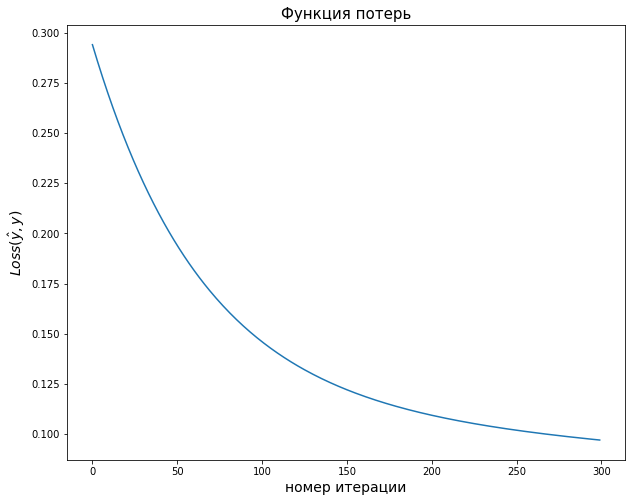

CPU times: user 252 ms, sys: 11.9 ms, total: 264 ms
Wall time: 262 ms


In [ ]:
%%time

neuron_relu = NeuronReLU()
Loss_values = neuron_relu.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

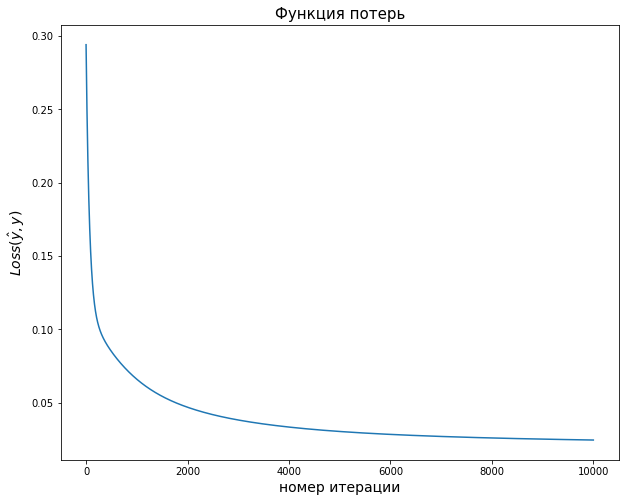

CPU times: user 991 ms, sys: 1.51 ms, total: 992 ms
Wall time: 992 ms


In [ ]:
%%time

neuron_relu = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron_relu.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как предсказывает этот нейрон:

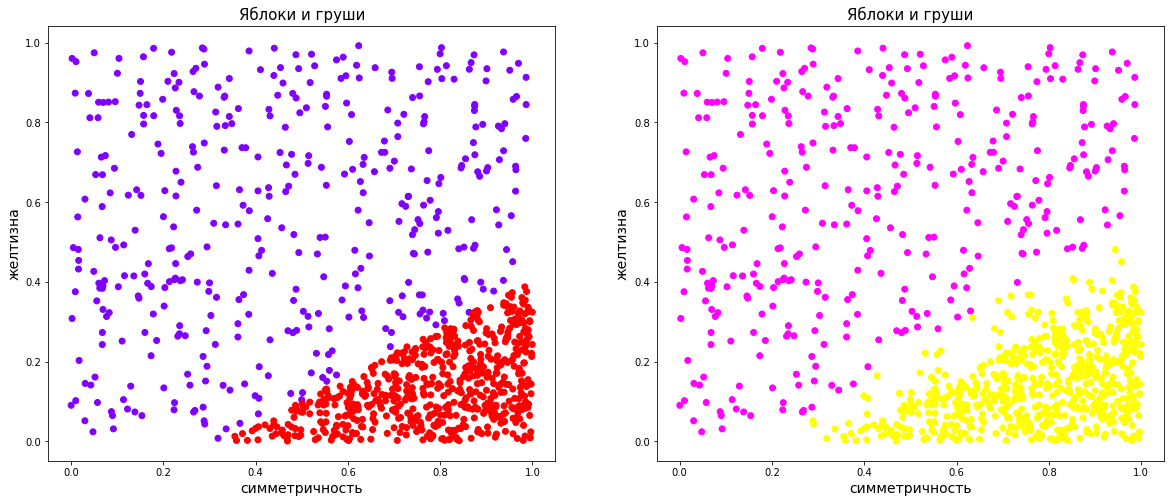

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=neuron_relu.predict(X).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()

In [ ]:
accuracy_score(neuron_relu.predict(X).ravel(), y)

0.952

Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

### Голос

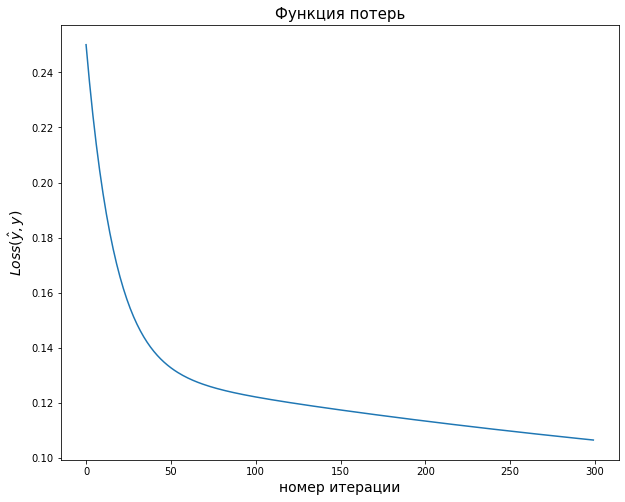

CPU times: user 337 ms, sys: 188 ms, total: 525 ms
Wall time: 333 ms


In [ ]:
%%time

neuron_relu_v = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron_relu_v.fit(X_v, y_v)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

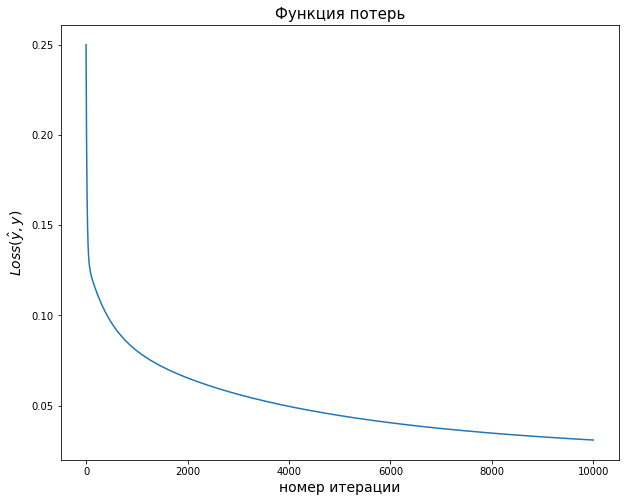

CPU times: user 3.12 s, sys: 2.72 s, total: 5.84 s
Wall time: 3.81 s


In [ ]:
%%time

neuron_relu_v = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron_relu_v.fit(X_v, y_v, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
accuracy_score(y_v, neuron_relu_v.predict(X_v)).round(4)

0.9473

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

# Нейрон с LeakyReLU (Leaky Recitified Linear Unit)

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [ ]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x > 0, x, x * alpha)

In [ ]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x > 0, 1, alpha)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return leaky_relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w -= learning_rate * (X.T @ (sigma - y)) / n
        self.b -= learning_rate * np.mean(sigma - y)


    def predict(self, X):
        return np.around(self.forward_pass(X))
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

# Тестирование нейрона с LeakyReLu

## Яблоки и груши

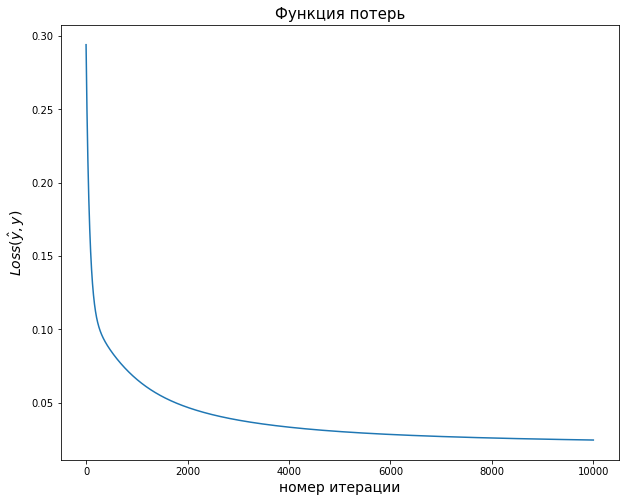

CPU times: user 1.05 s, sys: 13.2 ms, total: 1.06 s
Wall time: 1.07 s


In [ ]:
%%time

neuron_l = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values_l = neuron_l.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_l)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

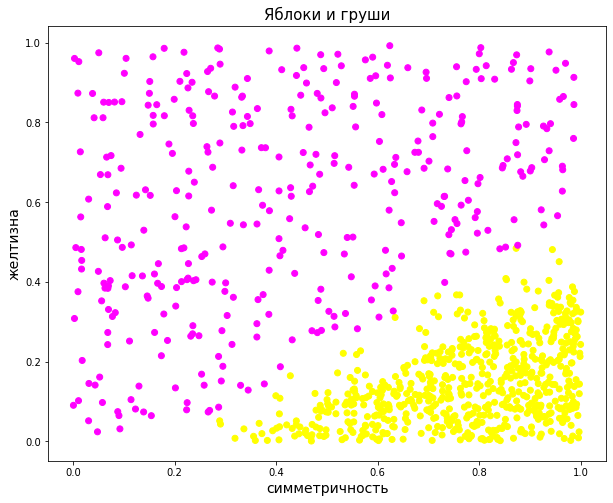

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=neuron_l.predict(X).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()

In [ ]:
accuracy_score(y, neuron_l.predict(X))

0.951

## Голос

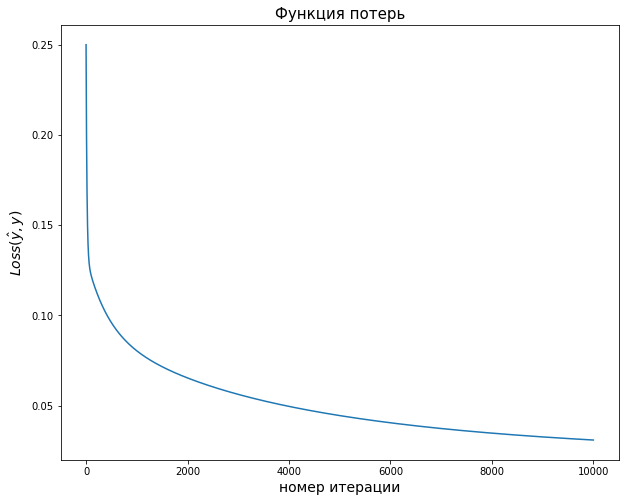

CPU times: user 3.19 s, sys: 2.24 s, total: 5.43 s
Wall time: 2.91 s


In [ ]:
%%time

neuron_l = NeuronLeakyReLU()
Loss_values_l = neuron_l.fit(X_v, y_v, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_l)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
accuracy_score(y_v, neuron_l.predict(X_v)).round(4)

0.95

# Нейрон с ELU (Exponential Linear Unit)

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [ ]:
from math import e

In [ ]:
def eelu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return x if x >= 0 else alpha*(e**x -1)

In [ ]:
def elu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return 1 if x > 0 else (eelu(x,alpha) + alpha)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        func = np.vectorize(eelu)
        return func(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        func = np.vectorize(elu_derivative)
        der = func(X)
        self.w -= learning_rate * (X.T @ (sigma - y) * der) / n
        self.b -= learning_rate * np.mean(sigma - y)
    
    def predict(self, X):
        return np.around(self.forward_pass(X))


    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

In [ ]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X_t = np.array([[1., 3.],
              [2., 4.],
              [-1., -3.2]])

neuron = NeuronELU(w, b)
y_pred = neuron.forward_pass(X_t)
print ("y_pred = " + str(y_pred))

y_pred = [[ 9.00000000e+00]
 [ 1.20000000e+01]
 [-9.95483419e-03]]


In [ ]:
y_t = np.array([1, 0, 1]).reshape(3, 1)

In [ ]:
fun = np.vectorize(elu_derivative)
der = fun(X_t)
print(der)

[[1 1]
 [1 1]
 [0 0]]


**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU

# Сравнение с моделями из коробки

In [ ]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_relu = keras.Sequential([
    layers.Dense(units=1, input_shape=(2,), activation='relu')
])
model_relu.compile(loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_relu.fit(X, y, epochs = 1000)

Epoch 1/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.5730
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.5600
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5707 - accuracy: 0.5370
Epoch 4/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.5010
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.4810
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.4550
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.4520
Epoch 8/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.4520
Epoch 9/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.4440
Epoch 10/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4509 - accuracy: 0.4480

`Accuracy` модели на датасете "Яблоки и груши" колеблется в районе 0.9660-0.9680, что немного лучше нашего результата в 0.952.

In [ ]:
model_relu_v = keras.Sequential([
    layers.Dense(units=1, input_shape=(20,), activation='relu')
])
model_relu_v.compile(loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model_relu_v.fit(X_v, y_v, epochs = 1000)

Epoch 1/1000
99/99 [==============================] - 0s 4ms/step - loss: 0.1895 - accuracy: 0.7459
Epoch 2/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.7854
Epoch 3/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.1564 - accuracy: 0.8153
Epoch 4/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.8438
Epoch 5/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.8564
Epoch 6/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.8722
Epoch 7/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1163 - accuracy: 0.8829
Epoch 8/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.8898
Epoch 9/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.8952
Epoch 10/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9015

На коробочном нейроне в случае с данными "Голос" получили `accuracy` 0.9738 на 1000 эпохе. Я не брала так много эпох, как для написанного вручную нейрона, потому что тут `accuracy` намного быстрее встает на плато. Тут различия с рукописным нейроном побольше, у него `accuracy` на тех же X_v и y_v равна 0.9473

In [ ]:
model_l = keras.Sequential([                                 
          keras.layers.Dense(units=1, input_shape = (2,),
              activation=keras.layers.LeakyReLU())                         
])

In [ ]:
model_l.compile(loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model_l.fit(X, y, epochs = 1000)

Epoch 1/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.0082 - accuracy: 0.4120
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.9743 - accuracy: 0.4120
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.9431 - accuracy: 0.4120
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.9128 - accuracy: 0.4120
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.8832 - accuracy: 0.4120
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.8540 - accuracy: 0.4120
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.8257 - accuracy: 0.4120
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7986 - accuracy: 0.4120
Epoch 9/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.7722 - accuracy: 0.4120
Epoch 10/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.7462 - accuracy: 0.4120

На "Грушах" `LeakyReLU` показала 0.956 против моих 0.951.

In [ ]:
model_l_v = keras.Sequential([                                 
          keras.layers.Dense(units=1, input_shape = (20,),
              activation=keras.layers.LeakyReLU())                         
])
model_l_v.compile(loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model_l_v.fit(X_v, y_v, epochs = 1000)

Epoch 1/1000
99/99 [==============================] - 1s 2ms/step - loss: 0.4599 - accuracy: 0.5073
Epoch 2/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.2598 - accuracy: 0.5694
Epoch 3/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.2331 - accuracy: 0.6253
Epoch 4/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.6531
Epoch 5/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.6834
Epoch 6/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 0.7159
Epoch 7/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.7459
Epoch 8/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.7721
Epoch 9/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1470 - accuracy: 0.8011
Epoch 10/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.8283

И на "Голосе" ~0.97 против 0.95 на моей реализации.

Получается, машины меня победили... (немножко) 😿